In [2]:
import cv2
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from PIL import Image
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import matplotlib.pyplot as plt

In [3]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding):
        super(conv2DBatchNormRelu, self).__init__()

        self.unit = nn.Sequential(
            nn.Conv2d(int(in_channels), int(n_filters), kernel_size=k_size, padding=padding, stride=stride),
            nn.BatchNorm2d(int(n_filters)),
            nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        return self.unit(inputs)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            conv2DBatchNormRelu(3, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1)
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            conv2DBatchNormRelu(64, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            conv2DBatchNormRelu(128, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1)
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            conv2DBatchNormRelu(256, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1)
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        self.bottle_neck = nn.Sequential(
            conv2DBatchNormRelu(512, 1024, 1, 1, 0),
            conv2DBatchNormRelu(1024, 512, 1, 1, 0)
        )

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            conv2DBatchNormRelu(512*2, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            conv2DBatchNormRelu(256*2, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            conv2DBatchNormRelu(128*2, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            conv2DBatchNormRelu(64*2, 1, 3, 1, 1),
            conv2DBatchNormRelu(1, 1, 3, 1, 1),

            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(pre_e3)

        # bottleneck
        bottle_neck = self.bottle_neck(e3)

        # decoder
        d3 = self.dec_conv3(torch.cat([self.upsample3(bottle_neck, ind3), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3, ind2), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2, ind1), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1, ind0), pre_e0], 1))

        # no activation
        return d0

In [4]:
model = UNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/microscope_images/unet_model.pth', map_location='cpu'))
model.eval()

UNet(
  (enc_conv0): Sequential(
    (0): conv2DBatchNormRelu(
      (unit): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): conv2DBatchNormRelu(
      (unit): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): conv2DBatchNormRelu(
      (unit): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): conv2DBatchNormRel

In [5]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy array to PIL Image
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = cv2.imread("/content/drive/MyDrive/microscope_images/dataset_2fold8/image/piece_5_microscope_image_109.png")
image_rgb = transform(image).unsqueeze(0)

In [6]:
with torch.no_grad():
    output = model(image_rgb)

output = output.squeeze().detach()
final = torch.ones_like(output) * (output > 4)
final = final.numpy()

In [7]:
mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(final)
rps = regionprops(mask_labeled)
areas = [r.area for r in rps]
clear = [x for x in areas if x >= 100]
idxs = np.argsort(areas)[::-1]
result_image = np.zeros_like(final)
for i in idxs[:len(clear)]:
    result_image[tuple(rps[i].coords.T)] = i+1

result_image = result_image > 0
result_image = result_image * 255
result_image = result_image.astype(np.uint8)
resized_image = cv2.resize(result_image, (262, 373))

No of circles:  47


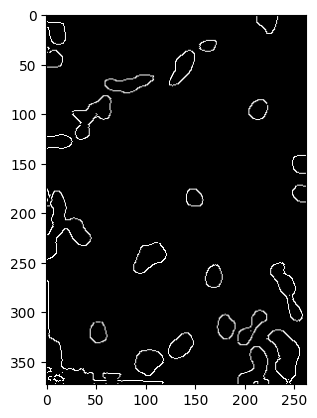

In [8]:
plt.imshow(resized_image, cmap='gray')
blur = cv2.GaussianBlur(resized_image, (11, 11), 0)
plt.imshow(blur, cmap='gray')
canny = cv2.Canny(blur, 30, 40, 3)
plt.imshow(canny, cmap='gray')
dilated = cv2.dilate(canny, (1, 1), iterations=0)
plt.imshow(dilated, cmap='gray')
(cnt, hierarchy) = cv2.findContours(
dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
cv2.drawContours(rgb, cnt, -1, (255, 0, 255), 1)
print("No of circles: ", len(cnt))

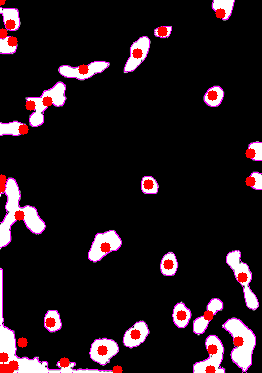

In [10]:
from google.colab.patches import cv2_imshow

for contour in cnt:
    M = cv2.moments(contour)

    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0

    cv2.circle(rgb, (cx, cy), 5, (0, 0, 255), -1)

cv2_imshow(rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()

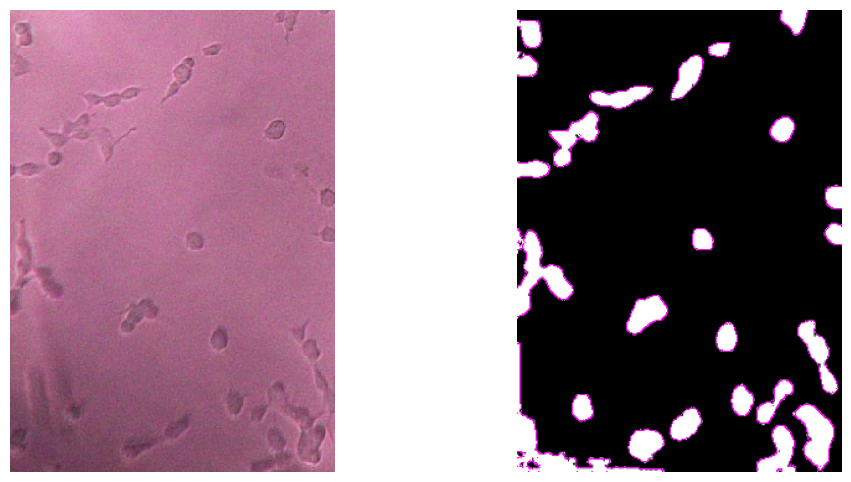

In [9]:
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

fig.add_subplot(1, 2, 2)
plt.imshow(rgb)
#plt.scatter(X_coord, Y_coord, color='red', marker='o', label='Точки')
plt.axis('off')
plt.show()